# 🚍 GTFS Data Processing Script

This script is designed to **read and process GTFS files** stored in a ZIP archive. It extracts all the relevant `.txt` files, converts them into **pandas DataFrames**, and dynamically assigns them to variables for streamlined transit data analysis. 

---

### 🔑 Key Features
#### 1. **File Extraction**  
- Opens the ZIP archive containing GTFS files.  
- Filters and processes only `.txt` files.  

### ⚠️ Important Note
Ensure that the ZIP file (e.g., `improved-gtfs-ttc-schedules.zip`) is located in the **same folder as the script**.  
- If the ZIP file is in a different directory, you need to **modify the `zip_path` variable** to reflect its correct file path.  

Example:
```python
zip_path = "path/to/your/gtfs-file.zip"


You should modify "City_Name" based on your Case study.

#### 2. **DataFrame Creation**  
- Reads each GTFS `.txt` file into a **pandas DataFrame**.  
- Stores DataFrames in a dictionary for organized access.  

#### 3. **Dynamic Variable Assignment**  
- Each DataFrame is dynamically assigned as a **global variable**, named after the file (excluding the `.txt` extension).  

#### 4. **Output Summary**  
- Displays the list of processed GTFS file names.  
- Shows the **total number of files** processed, for a quick overview.

---

### 📊 Benefits
- **Structured Data Handling**: Organizes GTFS data for easy querying and analysis.  
- **Scalability**: Automatically adapts to varying numbers of GTFS files.  
- **Transparency**: Outputs a clear summary for better visibility of processed data.

---





In [35]:
import os
import zipfile
import pandas as pd
from datetime import datetime, timedelta
import folium
from fpdf import FPDF
from PIL import Image
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
import folium
from folium import plugins

In [36]:

# Search for the ZIP file in the current directory
zip_files = [f for f in os.listdir('.') if f.endswith('_GTFS.zip')]

# Ensure there is exactly one ZIP file
if len(zip_files) != 1:
    raise FileNotFoundError(f"Expected exactly one ZIP file with pattern '*_GTFS.zip', but found: {zip_files}")

# Path to the found ZIP file
zip_path = zip_files[0]

# Extract City_Name from the ZIP file name (before the first underscore)
City_Name = zip_path.split('_')[0]

# Dictionary to store DataFrames with file names as keys
dataframes = {}

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Iterate over all files in the ZIP archive
    for file_name in zip_ref.namelist():
        if file_name.endswith('.txt'):  # Only process text files
            with zip_ref.open(file_name) as file:
                # Read each file into a DataFrame and save to dictionary
                df_name = file_name.split(".")[0]  # Use file name without extension as variable name
                dataframes[df_name] = pd.read_csv(file)
                # Dynamically assign DataFrame to a variable
                globals()[df_name] = dataframes[df_name]



print(f"Files in GTFS Of {City_Name}:")
print("=" * 30)  # Separator for better readability

# Iterate through the DataFrames and print the file names
for i, name in enumerate(dataframes.keys(), start=1):
    print(f"{i}. {name}")

print("\nTotal Files Processed:", len(dataframes))


Files in GTFS Of San Diego:
1. agency
2. calendar
3. calendar_dates
4. routes
5. stops
6. stop_times
7. transfers
8. shapes
9. fare_rules
10. fare_attributes
11. trips
12. feed_info

Total Files Processed: 12


/var/folders/fc/mkj1rmtd1fxdvgn96m4pmp1w0000gn/T/ipykernel_35409/2657388934.py:25: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file)


In [37]:
# Sort the DataFrame by trip_id and stop_sequence
stop_times = stop_times.sort_values(by=['trip_id', 'stop_sequence']).reset_index(drop=True)

# Recount stop_sequence for each trip_id
stop_times['stop_sequence'] = stop_times.groupby('trip_id').cumcount() + 1



# List of columns to check for NaN or empty values
columns_to_check = ['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence', 'shape_dist_traveled']

# Drop rows where any of the specified columns are NaN or empty
shapes = shapes.dropna(subset=columns_to_check)

# Alternatively, you can remove rows with empty strings too
shapes = shapes[~shapes[columns_to_check].isin(['']).any(axis=1)]


shapes = shapes.sort_values(by=['shape_id', 'shape_pt_sequence']).reset_index(drop=True)

shapes['shape_pt_sequence'] = shapes.groupby('shape_id').cumcount() + 1

shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,561-105_0_98,32.754669,-117.199219,1,0.0
1,561-105_0_98,32.754482,-117.199135,2,22.2
2,561-105_0_98,32.754341,-117.199013,3,41.6
3,561-105_0_98,32.754322,-117.198952,4,47.7
4,561-105_0_98,32.754253,-117.198776,5,65.9
...,...,...,...,...,...
52106,561-S2_550_8_3,32.715637,-117.153770,45,3793.1
52107,561-S2_550_8_3,32.706818,-117.153709,46,4774.0
52108,561-S2_550_8_3,32.706661,-117.153687,47,4791.6
52109,561-S2_550_8_3,32.706554,-117.153656,48,4803.9


## Code Explanation: Mapping Route Types to Transportation Modes

This script processes the `routes` DataFrame, which contains information about transit routes, by performing the following tasks:

1. **Mapping numeric route types to human-readable transportation modes**
2. **Counting the frequency of each mode** and displaying the results
3. If the `route_type` column is missing, an error message is printed.

### Steps:

1. **Define a Mapping for Route Types**

   A dictionary, `route_type_mapping`, is created to map **numeric route types** to **descriptive transportation modes**. Each value in the `route_type` column (which is numeric) corresponds to a specific mode of transport.

   ```python
   route_type_mapping = {
       0: "Streetcar", 1: "Subway", 2: "Rail", 3: "Bus", 4: "Ferry",
       5: "Cable Tram", 6: "Aerial Lift", 7: "Funicular", 11: "Trolleybus", 12: "Monorail"
   }


In [38]:

Total_number_routes = len(routes)

# Define a mapping for the route_type values to their corresponding transportation modes
route_type_mapping = {
    0: "Streetcar",
    1: "Subway",
    2: "Rail",
    3: "Bus",
    4: "Ferry",
    5: "Cable Tram",
    6: "Aerial Lift",
    7: "Funicular",
    11: "Trolleybus",
    12: "Monorail"
}



# Check if 'route_type' column exists in the 'routes' dataframe
if 'route_type' in routes.columns:
    # Map the 'route_type' values to their corresponding mode names
    routes['GTFS_modes'] = routes['route_type'].map(route_type_mapping)
    
    # Count the occurrences of each route type
    route_type_counts = routes['GTFS_modes'].value_counts()
    
    # Display the counts of each route type
    print(route_type_counts)
    
    # Convert the series to a DataFrame
    route_type_df = route_type_counts.reset_index()
    route_type_df.columns = ['Mode', 'Number of routes']
    

else:
    print("'route_type' column is not present in the 'routes' dataframe.")


GTFS_modes
Bus          99
Streetcar     5
Ferry         1
Name: count, dtype: int64


In [39]:
shape_route = trips[['route_id', 'shape_id']].drop_duplicates()
shape_route = shape_route.merge(routes[['route_id','route_type','route_color']], on='route_id', how='left')

route_type_mapping = {
    0: "Streetcar",
    1: "Subway",
    2: "Rail",
    3: "Bus",
    4: "Ferry",
    5: "Cable Tram",
    6: "Aerial Lift",
    7: "Funicular",
    11: "Trolleybus",
    12: "Monorail"
}
shape_route['modes'] = shape_route['route_type'].map(route_type_mapping)

# Keep rows where 'shape_id' is NOT NaN
shape_route = shape_route[~pd.isna(shape_route['shape_id'])]


## Code Explanation: Counting the Total Number of Unique Stops

This script counts and displays the total number of unique stops from the `stops` DataFrame.

### Steps:

1. **Count the Unique Stops**

   The `nunique()` function is used to count the number of unique `stop_id` values in the `stops` DataFrame. This gives the total number of distinct stops.

   ```python
   Num_stop = stops['stop_id'].nunique()


In [40]:
Num_stop = stops['stop_id'].nunique()
print(f'Total number of stops: {Num_stop}')


Total number of stops: 4360


# 🌍 **Visualizing Transit Routes on a Map**

This script is used to visualize a set of transit routes on an interactive map. It works with a dataset (in this case, the `shapes` DataFrame) that contains geographical data for the routes of a public transit system. The goal of the code is to create a map that shows these routes as lines, allowing you to see the paths they take geographically.

## 🔑 **Key Steps in the Code:**

1. **Calculate the Center of the Map**:
   The map's center is determined by averaging the latitude and longitude values from the dataset. This helps ensure that the map is initially centered on the transit routes.

2. **Create a Map with Folium**:
   Using the Folium library, the script initializes an interactive map centered at the previously calculated coordinates. The zoom level is set to a default value of 10 to give a good overview of the area covered by the routes.

3. **Loop Through Each Route**:
   The code then iterates over each unique transit route (`shape_id`) in the dataset. For each route, it extracts the corresponding latitude and longitude data and prepares it to be plotted as a polyline (a line connecting points) on the map.

4. **Draw Routes on the Map**:
   Each route is drawn on the map as a blue polyline. The coordinates are connected in the order they appear in the dataset, visualizing the path of the route.

5. **Display the Map**:
   Finally, the map is displayed with all the routes overlaid as blue lines. This interactive map allows users to zoom, pan, and explore the transit network visually.

---

In summary, the code creates a visual representation of a public transit system’s routes on a map, making it easier to understand the geographical layout of the network. The script works by calculating the center of the map, plotting the routes as blue lines, and displaying the map with all the routes drawn.


In [41]:
# Define the mode-to-color mapping
mode_color_mapping = {
    "Streetcar": "#4169E1",   # Blue for Streetcar
    "Subway": "#00FF00",      # Yellow for Subway
    "Rail": "#20B2AA",        # Black for Rail
    "Bus": "#FF0000",         # Red for Bus
    "Ferry": "#FFD700",       # Light Sea Green for Ferry (distinctive)
    "Cable Tram": "#FFFF00",  # Purple for Cable Tram
    "Aerial Lift": "#FFD700", # Gold for Aerial Lift (distinctive)
    "Funicular": "#FF4500",   # Orange Red for Funicular (distinctive)
    "Trolleybus": "#808080",  # Gray for Trolleybus (distinctive)
    "Monorail": "#800080"     # Lime Green for Monorail (distinctive)
}


center_lat = shapes['shape_pt_lat'].mean()
center_lon = shapes['shape_pt_lon'].mean()

# Create the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)

# Add a tile layer with opacity control
folium.TileLayer(
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='OpenStreetMap',
    name='Custom Background',
    opacity=0.4  # Set the desired opacity
).add_to(m)
ax = shape_route.sort_values(by='modes')
# Plot shapes
for shape_id in ax['shape_id'].unique():
    mode = shape_route.loc[shape_route['shape_id'] == shape_id, 'modes'].iloc[0]
    color = mode_color_mapping.get(mode, '#000000')
    shape_data = shapes[shapes['shape_id'] == shape_id]
    shape_coords = shape_data[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
    folium.PolyLine(shape_coords, color=color).add_to(m)

# Add layer control to toggle layers
folium.LayerControl().add_to(m)

m


In [42]:
ax[pd.isna(ax['shape_id'])]

,route_id,shape_id,route_type,route_color,modes


# 🚍 **Public Transit Network Visualization and Export to PNG**

This code demonstrates how to visualize a **public transit network** and export it as a high-quality PNG image using the **Matplotlib** library. It allows you to adjust several visual elements like **font type**, **font size**, and **figure title**, as well as **save the figure** with high resolution.

## 🔑 **Key Features of the Code:**

1. **📐 Set Font Type Globally**
You can customize the **font type** used in the plot by setting it globally with `rcParams`. In this example, **Times New Roman** is set as the font, but you can replace it with any font of your choice (e.g., `'Arial'`, `'serif'`).




2. 📊 Create the Plot
The code creates a figure with the specified size (10x7 inches) using plt.figure(). Then, it iterates over the unique shape_id values in the dataset, plotting each route as a blue line.


3. 📝 Customize Labels and Title
The title, x-axis, and y-axis labels are customized with the desired font type ('Times New Roman'), font size, and font weight (bold).


4. 🗺️ Add Grid for Better Readability
A grid is added to the plot to improve readability. The grid lines are dashed and have partial transparency (alpha = 0.5).



5. 💾 Save the Plot as a High-Resolution PNG
The plot is saved as a PNG file with a high resolution of 300 DPI. The bbox_inches='tight' ensures that the image is saved with minimal padding around the figure.


6. 👀 Display the Plot
The plot is displayed on the screen for immediate viewing.

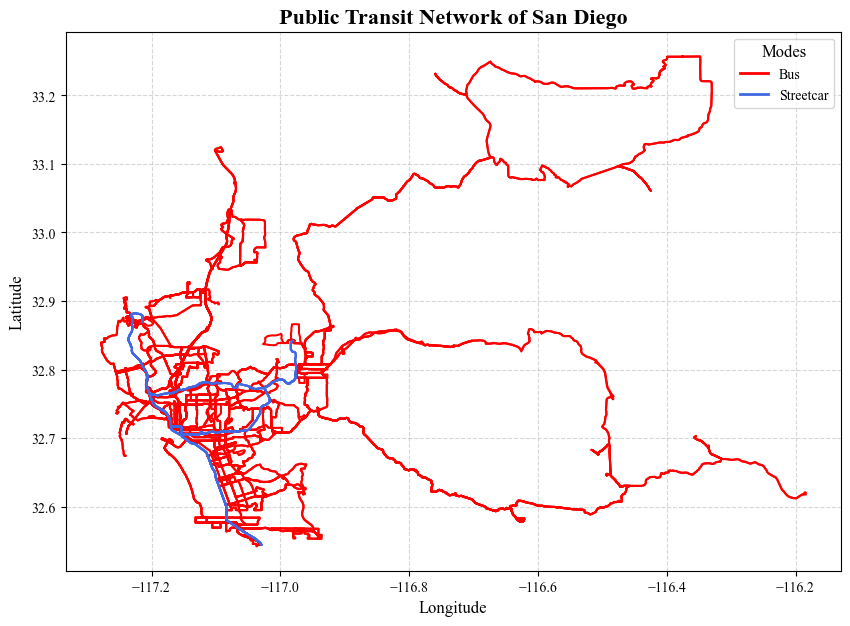

In [43]:


# Set the font type globally using rcParams
rcParams['font.family'] = 'Times New Roman'

# Create a plot
plt.figure(figsize=(10, 7))
ax = shape_route.sort_values(by='modes')

# List to store legend entries
legend_entries = []

# Iterate through unique shape IDs and plot their respective lines
for shape_id in ax['shape_id'].unique():
    mode = shape_route.loc[shape_route['shape_id'] == shape_id, 'modes'].iloc[0]

    # Get the color for the mode
    color = mode_color_mapping.get(mode, '#000000')
    
    # Plot the shape
    shape_data = shapes[shapes['shape_id'] == shape_id]
    plt.plot(
        shape_data['shape_pt_lon'],
        shape_data['shape_pt_lat'],
        color=color
    )

    # Add to legend entries if the mode is not already in the list
    if mode not in [entry.get_label() for entry in legend_entries]:
        legend_entries.append(Line2D([0], [0], color=color, lw=2, label=mode))

# Add the legend
plt.legend(handles=legend_entries, title='Modes', fontsize=10, title_fontsize=12, loc='upper right')

# Add labels and title with custom fonts
plt.title(f'Public Transit Network of {City_Name}', fontsize=16, fontweight='bold', fontfamily='Times New Roman')
plt.xlabel('Longitude', fontsize=12, fontfamily='Times New Roman')
plt.ylabel('Latitude', fontsize=12, fontfamily='Times New Roman')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot as a PNG file with 300 DPI
plt.savefig('network_visualization.png', dpi=300, bbox_inches='tight')  # Save with high resolution

# Display the plot
plt.show()


## GTFS Files: `calendar.txt` and `calendar_dates.txt`

Two important feeds in GTFS are `calendar.txt` and `calendar_dates.txt`. These files serve distinct but complementary roles in defining and managing transit schedules.

### 1. `calendar.txt`
- **Purpose**: Defines the regular schedule for a transit agency's services.
- **Content**: Each entry specifies the days of the week a particular service operates within a defined date range.

### 2. `calendar_dates.txt`
- **Purpose**: Handles exceptions to the regular schedule, such as holiday schedules or special events.

---

### Challenge in GTFS Files
Despite their importance, GTFS files present several challenges:
- **Limitations**: One significant challenge is the difficulty in identifying dates with similar services directly from the data.
- The GTFS structure does not inherently support grouping dates based on their service characteristics.

---

### Solution: Grouping Dates with Similar Services
In the following codes, we address this challenge by identifying and grouping dates with similar services, thus enhancing the ability to explore and analyze the transit network and schedule.

---

### Expected Output
At the end of the process, we will have a **DataFrame** that categorizes dates with similar services, allowing for better analysis of transit operations.


In [44]:
unique_service_ids = trips['service_id'].unique()

if "calendar" in dataframes:
    calendar_exist = True

if "calendar_dates" in dataframes:
    calendar_dates_exist = True


if calendar_exist:
    # Filter calendar DataFrame to keep only the service_ids in unique_service_ids
    calendar = calendar[calendar['service_id'].isin(unique_service_ids)]
    calendar.reset_index(drop=True, inplace=True)

    calendar['start_timestamp'] = pd.to_datetime(calendar['start_date'], format='%Y%m%d')
    calendar['start_timestamp'] = calendar['start_timestamp'].dt.date

    calendar['end_timestamp'] = pd.to_datetime(calendar['end_date'], format='%Y%m%d')
    calendar['end_timestamp'] = calendar['end_timestamp'].dt.date

    column_order = ['service_id','monday','tuesday','wednesday','thursday','friday','saturday','sunday','start_timestamp','end_timestamp','start_date','end_date']
    calendar = calendar[column_order]

if  calendar_dates_exist:
    # Filter calendar_dates DataFrame to keep only the service_ids in unique_service_ids
    calendar_dates = calendar_dates[calendar_dates['service_id'].isin(unique_service_ids)]
    calendar_dates.reset_index(drop=True, inplace=True)
    calendar_dates['timestamp'] = pd.to_datetime(calendar_dates['date'], format='%Y%m%d')
    calendar_dates['timestamp'] = calendar_dates['timestamp'].dt.date

    column_order = ['service_id','date','timestamp','exception_type']
    calendar_dates = calendar_dates[column_order]


In [45]:



if calendar_exist:
    # Convert int64 to datetime objects
    start_date1 = pd.to_datetime(calendar['start_timestamp'].min())
    end_date1 = pd.to_datetime(calendar['end_timestamp'].max())
    d1 = calendar['service_id']
if calendar_dates_exist:
    # Convert int64 to datetime objects
    start_date2 = pd.to_datetime(calendar_dates['timestamp'].min())
    end_date2 = pd.to_datetime(calendar_dates['timestamp'].max())
    d2 = calendar_dates['service_id']

if calendar_exist & calendar_dates_exist:
    start_date = min (start_date1,start_date2)
    end_date = max(end_date1,end_date2)
elif calendar_exist:
    start_date = start_date1
    end_date = end_date1
elif calendar_dates_exist:
    start_date = start_date2
    end_date = end_date2



# Generate a range of dates between start_date and end_date
date_range = pd.date_range(start_date, end_date)

# Create a DataFrame with date and day columns
df = pd.DataFrame({'date': date_range, 'day': date_range.day_name().str.lower()})

# Assuming start_date and end_date are datetime objects
formatted_start_date = start_date.strftime("%B %d, %Y")
formatted_end_date = end_date.strftime("%B %d, %Y")

print(f"Start Date: {formatted_start_date}")
print(f"End Date: {formatted_end_date}")



Start Date: September 01, 2024
End Date: January 25, 2025


In [46]:
if calendar_exist & calendar_dates_exist:
    # Concatenate the two Series
    combined_series = pd.concat([d1, d2])
elif calendar_exist:
    combined_series = d1
elif calendar_dates_exist:
    combined_series = d2

# Get unique values and create a DataFrame with a reset index
d = pd.DataFrame({'service_id': combined_series.unique()}).reset_index(drop=True)
for i in range (len(d)):
    tem = d.loc[i,'service_id']
    df[tem] = 0
dfcopy = df.copy()


In [47]:
service_id_counts = trips['service_id'].value_counts()
h = 2+len(d)
for i in range (len(df)):
    a = df.iloc[i,0].date()
    b = df.iloc[i,1]
    
    if calendar_exist:
        for k in range (len(calendar)):
            if (a >= calendar.iloc[k,8]) & (a <= calendar.iloc[k,9]) & (calendar.loc[k,b]==1):
                c = calendar.iloc[k,0]
                df.loc[i,c] = 1
                dfcopy.loc[i,c] = service_id_counts.at[c]

if calendar_dates_exist:
    for w in range(len(calendar_dates)):
        m = calendar_dates.iloc[w,0]
        n = datetime.strptime(str(calendar_dates.iloc[w,1]), '%Y%m%d').date() 
        l = calendar_dates.iloc[w,3]

        desired_row = df[df['date'].dt.date == n]
        q = desired_row.index[0]
        if l==1:
            if m in service_id_counts.index:
                
                df.loc[q,m] = 1
                dfcopy.loc[q,m] = service_id_counts.at[m]
        elif l ==2:
            df.loc[q,m] = 0
            dfcopy.loc[q,m] = 0
df_tempo = df.copy()
df['Number_of_Active_services'] = df.iloc[:, 2:h].sum(axis=1)
df['Number_of_Active_Trips'] = dfcopy.iloc[:,2:h].sum(axis=1)


In [48]:
 
# Create an empty list to store the results
result_list = []

# Iterate through rows
for index, row in df_tempo.iterrows():
    # Filter columns where the value is 1
    active_services = row.index[row.eq(1)].tolist()
    
    # Append the result to the list
    result_list.append({'date': row['date'],'day': row['day'], 'active_services': active_services})


# If you want to save the result to a file, you can use the following code
result_df = pd.DataFrame(result_list)
mergedresult_df = pd.merge(result_df, df[['Number_of_Active_services','Number_of_Active_Trips', 'date']], on='date', how='left')




# Assuming mergedresult_df is your dataframe

# Convert lists in 'active_services' column to tuples
mergedresult_df['active_services_tuple'] = mergedresult_df['active_services'].apply(tuple)

# Group by the new column 'active_services_tuple'
grouped = mergedresult_df.groupby('active_services_tuple')

# Aggregate dates within each group
dates_by_services = grouped['date'].agg(list)

# Create a dictionary to store categories
categories = {}
category_count = 1

# Loop through each group
for services, dates in dates_by_services.items():
    
    
    category_key = f'{category_count}'
    categories[category_key] = {'active_services': list(services), 'dates': dates}
    # Assign this category to each date in the group
    for date in dates:
        mergedresult_df.loc[mergedresult_df['date'] == date, 'category'] = category_key
    category_count += 1


# Drop the temporary column
mergedresult_df.drop(columns=['active_services_tuple'], inplace=True)



mergedresult_df.to_csv('Date_Classification.csv', index=False)

In [49]:

# Create lists to store data
category_names = []
active_services_lists = []
date_lists = []

# Iterate through categories
for category, data in categories.items():
    # Append category name
    category_names.append(category)
    # Append active services list
    active_services_lists.append(data['active_services'])
    # Append date list
    date_lists.append(data['dates'])

# Create DataFrame
category_df = pd.DataFrame({
    'category': category_names,
    'Active_Services': active_services_lists,
    'Date_List': date_lists
})

# Assuming 'categories' separate the time part from the date values in the category DataFrame
category_df['Date_List'] = category_df['Date_List'].apply(lambda dates: [date.strftime('%Y-%m-%d') for date in dates])


tempor = mergedresult_df[['Number_of_Active_Trips', 'category']].drop_duplicates()
category_df = pd.merge(category_df, tempor[['Number_of_Active_Trips', 'category']], on='category', how='left')
# Save DataFrame to CSV
category_df.to_csv('Category.csv', index=False)




In [50]:
max_row_index = df['Number_of_Active_Trips'].idxmax()
# Exclude the last two columns from the DataFrame
df_excluded = df.iloc[:, :-2]

# Get the list of columns where the value in the specified row is 1
columns_with_ones = df_excluded.columns[df_excluded.iloc[max_row_index] == 1].tolist()

In [51]:
column_order=['trip_id','arrival_time','departure_time','stop_id','stop_sequence']
newstop_times = stop_times[column_order]

In [52]:
mergedstop_times = pd.merge(newstop_times, trips[['service_id', 'trip_id']], on='trip_id', how='left')

In [53]:

column_order=['service_id','trip_id','arrival_time','departure_time','stop_id','stop_sequence']
mergedstop_times = mergedstop_times[column_order]
# Filter rows based on the desired service_ids
filteredmergedstop_times = mergedstop_times[mergedstop_times['service_id'].isin(columns_with_ones)]

In [54]:
filteredmergedroutestop_times = pd.merge(filteredmergedstop_times, trips[['route_id', 'trip_id']], on='trip_id', how='left')
column_order=['route_id','service_id','trip_id','arrival_time','departure_time','stop_id','stop_sequence']
filteredmergedroutestop_times = filteredmergedroutestop_times[column_order]
filteredmergedroutestop_timess = pd.merge(filteredmergedroutestop_times, stops[['stop_id', 'stop_lat','stop_lon']], on='stop_id', how='left')

filteredmergedroutestop_timess = pd.merge(filteredmergedroutestop_timess, trips[['trip_id', 'shape_id']], on='trip_id', how='left')
filteredmergedroutestop_timess = pd.merge(filteredmergedroutestop_timess, trips[['trip_id', 'block_id']], on='trip_id', how='left')
column_order=['route_id','service_id','trip_id','block_id','shape_id','arrival_time','departure_time','stop_id','stop_lat','stop_lon','stop_sequence']
DataFrame_BusiestDay = filteredmergedroutestop_timess[column_order]

In [55]:
# Assuming 'time_column' is the column containing the time in the format '12:25:04'
DataFrame_BusiestDay.loc[:, 'arivalTime_seconds'] = DataFrame_BusiestDay['arrival_time'].apply(
    lambda x: sum(int(i) * 60**(2 - idx) for idx, i in enumerate(x.split(':')))
)
DataFrame_BusiestDay.loc[:, 'departureTime_seconds'] = DataFrame_BusiestDay['departure_time'].apply(
    lambda x: sum(int(i) * 60**(2 - idx) for idx, i in enumerate(x.split(':')))
)
column_order=['route_id','service_id','trip_id','block_id','shape_id','arrival_time','arivalTime_seconds','departureTime_seconds','stop_id','stop_lat','stop_lon','stop_sequence']

DataFrame_BusiestDay = DataFrame_BusiestDay[column_order]



/var/folders/fc/mkj1rmtd1fxdvgn96m4pmp1w0000gn/T/ipykernel_35409/861379238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame_BusiestDay.loc[:, 'arivalTime_seconds'] = DataFrame_BusiestDay['arrival_time'].apply(
/var/folders/fc/mkj1rmtd1fxdvgn96m4pmp1w0000gn/T/ipykernel_35409/861379238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame_BusiestDay.loc[:, 'departureTime_seconds'] = DataFrame_BusiestDay['departure_time'].apply(


# Busiest Day info


In the following code, we find some parameters of the busiest day such the the number of routes, stops, trips, and blocks.

In [56]:
print("Some data for the busiest day")
print('')

num_routes_busiest_day = DataFrame_BusiestDay['route_id'].nunique()
print(f'Number of active routes: {num_routes_busiest_day}')
print('')

num_stops_busiest_day = DataFrame_BusiestDay['stop_id'].nunique()
print(f'Number of active stops: {num_stops_busiest_day}')
print('')

num_trips_busiest_day = DataFrame_BusiestDay['trip_id'].nunique()
print(f'Number of trips: {num_trips_busiest_day}')
print('')

num_blocks_busiest_day = DataFrame_BusiestDay['block_id'].nunique()
print(f'Number of blocks: {num_blocks_busiest_day}')

Some data for the busiest day

Number of active routes: 103

Number of active stops: 4232

Number of trips: 7872

Number of blocks: 631


In [57]:
# Start and end time intervals
start_time_intervals = [DataFrame_BusiestDay['arivalTime_seconds'].min(), 6 * 3600, 9 * 3600, 15 * 3600, 17 * 3600, 19 * 3600, 22 * 3600]
end_time_intervals = start_time_intervals[1:] + [DataFrame_BusiestDay['arivalTime_seconds'].max()]  

# Initialize dictionaries to store results
trips_in_day_period = {}
selected_trips_dict = {}

# Iterate through time intervals
for start, end in zip(start_time_intervals, end_time_intervals):
    # Select trips that start within the current interval
    selected_trips = DataFrame_BusiestDay[
        (DataFrame_BusiestDay['arivalTime_seconds'] >= start) & 
        (DataFrame_BusiestDay['arivalTime_seconds'] < end) & 
        (DataFrame_BusiestDay['stop_sequence'] == 1)
    ]
    
    # Count the number of unique trips within the interval
    num_trips = selected_trips['trip_id'].nunique()
    
    # Calculate the duration of the interval
    duration = (end - start)/3600

    last_time_interval = int(start_time_intervals[-1]/3600)

    if start == last_time_interval*3600:
        duration = round(selected_trips['arivalTime_seconds'].max()/3600)-start/3600

    
    # Store the selected trips in the dictionary
    day_period_key = f'{start//3600:02d}:00 - {end//3600:02d}:00' if start < last_time_interval * 3600 else f'{start//3600:02d}:00 - End of Service'
    trips_in_day_period[day_period_key] = {'num_trips': num_trips, 'duration': duration,'num_trip_per_hour': round(num_trips/duration)}
    selected_trips_dict[day_period_key] = selected_trips


for day_period, data in trips_in_day_period.items():
    print(f"Day Period: {day_period}, Number of Trips: {data['num_trips']}")





Day Period: 03:00 - 06:00, Number of Trips: 428
Day Period: 06:00 - 09:00, Number of Trips: 1546
Day Period: 09:00 - 15:00, Number of Trips: 2876
Day Period: 15:00 - 17:00, Number of Trips: 1078
Day Period: 17:00 - 19:00, Number of Trips: 930
Day Period: 19:00 - 22:00, Number of Trips: 752
Day Period: 22:00 - End of Service, Number of Trips: 262


In [58]:


# Prepare the data for the DataFrame
data_for_df = []
for i, (day_period, data) in enumerate(trips_in_day_period.items(), start=1):
    start_time, end_time = day_period.split(" - ") if " - " in day_period else (day_period[:-3], None)
    data_for_df.append({
        'Day period id': i,
        'Start time': start_time,
        'End time': end_time if end_time else "End of Service",
        'Duration (hour)': data['duration'],
        'No. of trips': data['num_trips'],
        'No. of trips per hour': round(data['num_trips']/data['duration'])
    })

# Create the DataFrame
day_periods_busiestday = pd.DataFrame(data_for_df)


# Find the Day period id with the maximum No. of trips per hour
max_day_period_id = day_periods_busiestday.loc[
    day_periods_busiestday['No. of trips per hour'].idxmax(), 'Day period id'
]
# Display the DataFrame
day_periods_busiestday


,Day period id,Start time,End time,Duration (hour),No. of trips,No. of trips per hour
0,1,03:00,06:00,2.133333,428,201
1,2,06:00,09:00,3.000000,1546,515
2,3,09:00,15:00,6.000000,2876,479
3,4,15:00,17:00,2.000000,1078,539
4,5,17:00,19:00,2.000000,930,465
5,6,19:00,22:00,3.000000,752,251
6,7,22:00,End of Service,5.000000,262,52


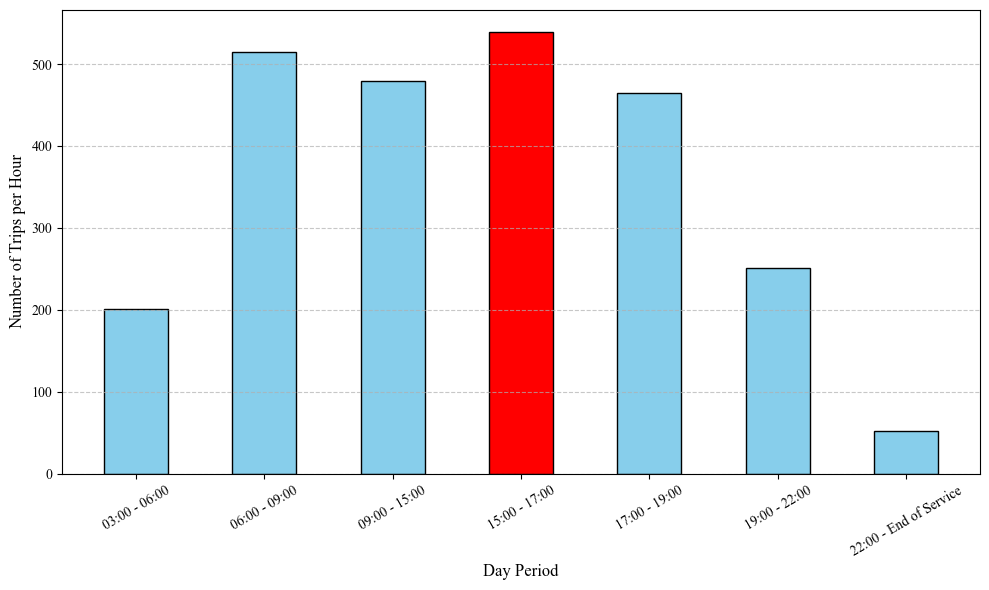

In [59]:
import matplotlib.pyplot as plt

# Extract intervals and trips per hour for plotting
intervals = list(trips_in_day_period.keys())
num_trips_per_hour = [data['num_trip_per_hour'] for data in trips_in_day_period.values()]

# Find the index of the maximum value (number of trips per hour)
max_index = num_trips_per_hour.index(max(num_trips_per_hour))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(intervals, num_trips_per_hour, color='skyblue', edgecolor='black', width=0.5)

# Highlight the maximum bar in red
bars[max_index].set_color('red')
bars[max_index].set_edgecolor('black')


# Customize the font and appearance
plt.xlabel("Day Period", fontsize=12, fontfamily='Times New Roman')
plt.ylabel("Number of Trips per Hour", fontsize=12, fontfamily='Times New Roman')
plt.xticks(rotation=30, fontsize=10, fontfamily='Times New Roman')  # Rotate the x-axis labels for better readability
plt.yticks(fontsize=10, fontfamily='Times New Roman')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as a PNG file with specified DPI
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig("trips_per_interval.png", dpi=300)

# Show the plot
plt.show()


-------
# Routes Description on the Busiest Day

The goal of the following code is to analyze transit data by aggregating it at the route level to determine the number of unique trips and blocks associated with each route. 
Additionally, it identifies the routes with the maximum number of blocks and trips, providing key insights into the busiest or most operationally intensive routes.


--------


In [60]:
route_dataframe = DataFrame_BusiestDay.groupby('route_id').agg({
    'trip_id': 'nunique',
    'block_id': 'nunique',

}).reset_index()


# Find the route with the maximum number of blocks
max_blocks_route_id = route_dataframe.loc[route_dataframe['block_id'].idxmax(), 'route_id']

max_blocks_route_value = route_dataframe.loc[route_dataframe['block_id'].idxmax(), 'block_id']


# Find the route with the maximum number of trips
max_trips_route_id = route_dataframe.loc[route_dataframe['trip_id'].idxmax(), 'route_id']
max_trips_route_value = route_dataframe.loc[route_dataframe['trip_id'].idxmax(), 'trip_id']

print(f"Route with maximum blocks: {max_blocks_route_id} ({max_blocks_route_value} blocks)")
print(f"Route with maximum trips: {max_trips_route_id} ({max_trips_route_value} trips)")

route_dataframe = route_dataframe.merge(routes[['route_id','agency_id','route_short_name','route_long_name','route_type']],on='route_id',how='left')

route_dataframe['mode'] = route_dataframe['route_type'].map(route_type_mapping)

route_dataframe = route_dataframe.drop('route_type', axis= 1)

Route with maximum blocks: 561-30 (28 blocks)
Route with maximum trips: 561-510 (293 trips)


In [61]:
sorted_routes = route_dataframe.sort_values(by="trip_id", ascending=False).reset_index(drop=True)
sorted_routes.rename(columns={"trip_id": "no. of trips", "block_id": "no. of blocks"}, inplace=True)
sorted_routes.rename(columns={"route_id": "route id", "agency_id": "agency"}, inplace=True)
sorted_routes.rename(columns={"route_short_name": "short name", "route_long_name": "long name"}, inplace=True)
sorted_routes = sorted_routes.drop('agency',axis=1)
top_routes = sorted_routes.iloc[:10, :]
top_routes


,route id,no. of trips,no. of blocks,short name,long name,mode
0,561-510,293,21,Blue,San Ysidro - Utc,Streetcar
1,561-227,194,24,227,Imperial Beach - Otay Mesa Tc,Bus
2,561-7,183,20,7,Downtown San Diego - University/College,Bus
3,561-215,174,12,215,Mid-City Rapid,Bus
4,561-13,158,17,13,Kaiser Hospital - 24th St Transit Center,Bus
5,561-3,151,12,3,Ucsd Hospital - Euclid Transit Center,Bus
6,561-12,151,20,12,City College - Skyline Hills,Bus
7,561-41,148,26,41,Fashion Valley - Ucsd,Bus
8,561-530,144,9,Green,Santee - 12th & Imperial,Streetcar
9,561-44,143,21,44,Old Town - Kearny Mesa,Bus


----------
# Trip Distribution
The primary goal of the following code is to analyze and visualize the distribution of trips across different routes in a transit system. 
It achieves this by processing data, identifying significant routes, and creating a histogram plot.

-----

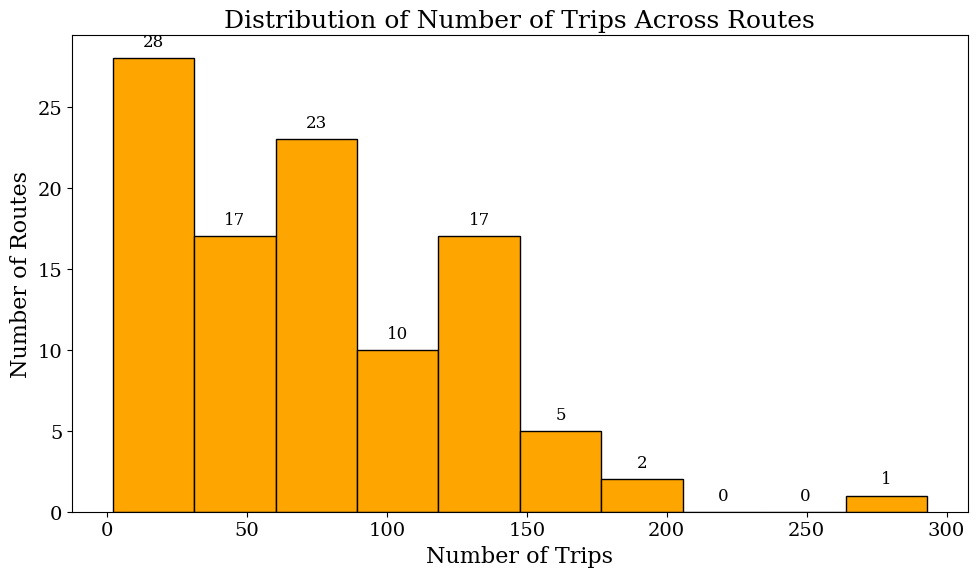

In [62]:



# Define font properties
font = {'family': 'serif', 'size': 14}

# Apply font properties globally
plt.rc('font', **font)

# Create the plot
plt.figure(figsize=(10, 6))
hist_values, bins, patches = plt.hist(route_dataframe['trip_id'], bins=10, color='orange', edgecolor='black')

# Add labels above each bar
for patch, value in zip(patches, hist_values):
    x = patch.get_x() + patch.get_width() / 2
    y = value
    plt.text(x, y + 0.5, f'{int(value)}', ha='center', va='bottom', fontsize=12)

# Customize labels and title
plt.xlabel('Number of Trips', fontsize=16)
plt.ylabel('Number of Routes', fontsize=16)
plt.title('Distribution of Number of Trips Across Routes', fontsize=18)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Routes_trips_histogram.png', dpi=300)
plt.show()



In [63]:
# Find the index of the highest frequency
max_freq_index = hist_values.argmax()

# Get the interval for the highest frequency bin as a list
highest_interval = [int(bins[max_freq_index]), int(bins[max_freq_index + 1])]



print(f"Highest Interval: {highest_interval} with frequency {int(hist_values[max_freq_index])}")

# Get the last interval as a list
last_interval = [int(bins[-2]), int(bins[-1])]
last_frequency = hist_values[-1]  # The last value in hist_values corresponds to the last bin


print(f"Last Interval: {last_interval} with frequency {int(last_frequency)}")



Highest Interval: [2, 31] with frequency 28
Last Interval: [263, 293] with frequency 1


In [64]:
dfcopy = DataFrame_BusiestDay[DataFrame_BusiestDay['stop_sequence'] == 1].reset_index(drop=True)

# Group by 'stop_id', 'stop_lat', and 'stop_lon' and calculate the number of unique trips
stops_trips = dfcopy.groupby(['stop_id', 'stop_lat', 'stop_lon']).agg(
    Num_trips=('trip_id', 'nunique')
).reset_index()

stops_trips

,stop_id,stop_lat,stop_lon,Num_trips
0,561-10001,32.674458,-117.240426,9
1,561-10332,32.709168,-117.009255,87
2,561-10357,32.795030,-117.252700,1
3,561-10762,32.795226,-117.252946,1
4,561-11107,32.845369,-117.273226,2
...,...,...,...,...
215,561-99570,32.706403,-117.238805,12
216,561-99581,32.780213,-117.097216,13
217,561-99582,32.780250,-117.097002,21
218,561-99589,32.717058,-117.169298,195


In [65]:


# Assuming 'stops_trips' contains 'stop_lat' and 'stop_lon' columns
coords = stops_trips[['stop_lat', 'stop_lon']].values

# Function to calculate the Haversine distance
def haversine_distance(coord1, coord2):
    # Convert coordinates to radians
    lat1, lon1 = np.deg2rad(coord1)
    lat2, lon2 = np.deg2rad(coord2)
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius = 6371000  # Radius of Earth in meters
    return radius * c

# Calculate the distance matrix
distance_matrix = np.zeros((len(coords), len(coords)))
for i in range(len(coords)):
    for j in range(len(coords)):
        distance_matrix[i, j] = haversine_distance(coords[i], coords[j])

# Apply Agglomerative Clustering with a maximum distance threshold (e.g., 250 meters)
threshold_distance = 500  # Adjust this as needed
agg_cluster = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=threshold_distance)
agg_cluster.fit(distance_matrix)

# Add cluster labels to the DataFrame
stops_trips['cluster'] = agg_cluster.labels_

# Calculate the centroid of each cluster
centroids = stops_trips.groupby('cluster').agg({
    'stop_lat': 'mean',
    'stop_lon': 'mean',
    'Num_trips': 'sum'  # Assuming 'Num_trips' is the column representing number of trips in the stpost_trips DataFrame
}).reset_index()

# Optionally, if you want to inspect the centroids DataFrame
centroids


,cluster,stop_lat,stop_lon,Num_trips
0,0,32.755238,-117.079893,37
1,1,32.716706,-117.163409,450
2,2,32.958732,-117.037601,30
3,3,32.687792,-117.084750,2
4,4,32.831215,-117.134587,235
...,...,...,...,...
112,112,32.807839,-116.923020,2
113,113,32.753423,-117.165010,74
114,114,32.755376,-117.108902,1
115,115,32.867239,-117.219378,29


----------
Explanation:
Map Initialization: The map is centered at the average latitude and longitude of all stops.
Cluster Colors: The cluster_colors dictionary assigns a unique color to each cluster. The colors are chosen based on the cluster index.
Stop Markers: For each stop, a CircleMarker is placed on the map, with the color corresponding to its cluster. The popup shows the stop ID and the number of trips.
Centroid Markers: For each cluster's centroid, a Marker is added with a red icon, and the popup displays information about the cluster.
Layer Control: Adds a control to toggle map layers (optional).
Save Map: The map is saved as an HTML file that you can open in any browser.

In [66]:


# Initialize a base map centered at the average latitude and longitude
center_lat = stops_trips['stop_lat'].mean()
center_lon = stops_trips['stop_lon'].mean()

# Create the map object
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define a color map for clusters
cluster_colors = {i: f"#{hex(255-i*20)[2:].zfill(2)}{hex(i*20)[2:].zfill(2)}00" for i in range(stops_trips['cluster'].nunique())}

# Add markers for each stop
for _, row in stops_trips.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=6,
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.7,
        popup=f"Stop ID: {row['stop_id']}<br>Trips: {row['Num_trips']}"
    ).add_to(m)

# Add markers for each centroid (cluster center)
for _, row in centroids.iterrows():
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=f"Cluster {row['cluster']}<br>Trips: {row['Num_trips']}",

    ).add_to(m)

# Optionally, add a Layer Control if you want to toggle between different layers (e.g., streets, satellite)
folium.LayerControl().add_to(m)



# To display the map inline in a Jupyter notebook (if needed):
m


In [67]:
trip_info = DataFrame_BusiestDay.groupby('trip_id').agg(
    route_id = ('route_id', 'first'),
    shape_id = ('shape_id', 'first'),
    Start_time=('arivalTime_seconds', 'min'),
    End_time=('arivalTime_seconds', 'max'),
).reset_index()
trip_info['trip_duration']=round((trip_info['End_time']-trip_info['Start_time'])/60)

# Convert Start_time and End_time from seconds to hour:min format
trip_info['Start_time_str'] = trip_info['Start_time'].apply(lambda x: f"{divmod(x // 60, 60)[0]:02}:{divmod(x // 60, 60)[1]:02}")
trip_info['End_time_str'] = trip_info['End_time'].apply(lambda x: f"{divmod(x // 60, 60)[0]:02}:{divmod(x // 60, 60)[1]:02}")

# Sort trips by route_id and Start_time
trip_info_sorted = trip_info.sort_values(by=['route_id','shape_id', 'Start_time']).reset_index(drop=True)




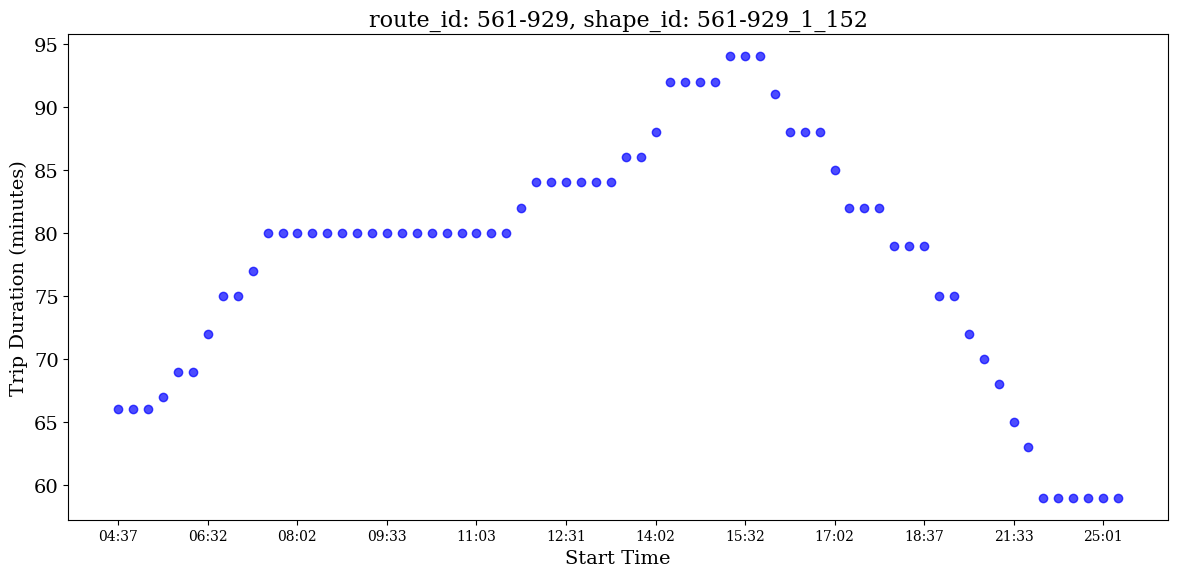

In [68]:
start_time_intervals = [0, 6 * 3600, 9 * 3600, 15 * 3600, 17 * 3600, 19 * 3600, 22 * 3600]


shape_trip_duration = trip_info_sorted.groupby('shape_id').agg(
    route_id = ('route_id', 'first'),
   
    trip_duration_mean=('trip_duration', 'mean'),
    trip_duration_std=('trip_duration', 'std'),
    num_trips = ('trip_id', 'nunique'),
).reset_index()

# Ensure there are no NaN values in the DataFrame
shape_trip_duration = shape_trip_duration.fillna(0)

shape_trip_duration = shape_trip_duration[shape_trip_duration['num_trips']>50].reset_index(drop=True)

# Find the row with the maximum value in 'trip_duration_std'
row_with_highest_std = shape_trip_duration.loc[shape_trip_duration['trip_duration_std'].idxmax()]


# Extract 'shape_id' and 'route_id' values
shape_id_with_highest_std = row_with_highest_std['shape_id']
route_id_with_highest_std = row_with_highest_std['route_id']


trips_crowdestroute = trip_info_sorted[(trip_info_sorted['route_id']==route_id_with_highest_std) & (trip_info_sorted['shape_id']==shape_id_with_highest_std)]
trips_crowdestroute = trips_crowdestroute.reset_index(drop=True)


import matplotlib.pyplot as plt

# Extract data for the specific crowded route
x_values = trips_crowdestroute['Start_time_str']
y_values = trips_crowdestroute['trip_duration']

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.7)

# Customize the plot
plt.xlabel('Start Time', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.title(f'route_id: {trips_crowdestroute.loc[0, 'route_id']}, shape_id: {trips_crowdestroute.loc[0, 'shape_id']}', fontsize=16)

# Set x-ticks to show fewer labels
step = max(1, len(x_values) // 10)  # Adjust the step size based on the number of points
plt.xticks(ticks=range(0, len(x_values), step), labels=x_values[::step], rotation=0, fontsize=10)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Trip_Duration.png', dpi=300)
plt.show()


In [69]:


# Iterate through the time intervals and create separate DataFrames
for i in range(len(start_time_intervals)):
    start = start_time_intervals[i]

    if i == len(start_time_intervals)-1:
        end = 36*3600
    else:
        end = start_time_intervals[i + 1]
    
    # Filter the DataFrame for the current interval
    filtered_df = trips_crowdestroute[
        (trips_crowdestroute['Start_time'] >= start) & 
        (trips_crowdestroute['Start_time'] < end)
    ]
    
    # Dynamically create variables like trips_timeinterval_1, trips_timeinterval_2, ...
    globals()[f"trips_timeinterval_{i + 1}"] = filtered_df




In [70]:


# Initialize an empty list to store the data for each day period
summary_data = []

# Iterate through the dynamically created variables
for i in range(len(start_time_intervals)):
    # Access the filtered DataFrame dynamically
    filtered_df = globals().get(f"trips_timeinterval_{i + 1}")
    
    if filtered_df is not None and not filtered_df.empty:
        # Calculate the required values
        day_period_id = i + 1
        no_of_trips = len(filtered_df)
        duration_mean = filtered_df['trip_duration'].mean() if 'trip_duration' in filtered_df.columns else None
        duration_std = filtered_df['trip_duration'].std() if 'trip_duration' in filtered_df.columns else None
        
        # Append the data as a dictionary
        summary_data.append({
            "Day Period ID": day_period_id,
            "No. of Trips": no_of_trips,
            "Mean Duration": int(round(duration_mean)),
            "Duration Std": int(round(duration_std))
        })

# Create a DataFrame from the summary data
summary_worstcase_day_period = pd.DataFrame(summary_data)

# Display the resulting DataFrame
summary_worstcase_day_period


,Day Period ID,No. of Trips,Mean Duration,Duration Std
0,1,4,66,0
1,2,12,76,4
2,3,24,83,4
3,4,8,91,3
4,5,7,81,2
5,6,6,71,4
6,7,7,60,2


In [71]:

shapes_length = shapes.groupby('shape_id').agg(
    length = ('shape_dist_traveled', 'max')
).reset_index()

block_info = DataFrame_BusiestDay[['block_id','shape_id','trip_id']].drop_duplicates()
block_info = block_info.merge(shapes_length[['shape_id','length']],on='shape_id',how='left')


block_info = block_info.groupby('block_id').agg(
    Num_trips=('trip_id', 'nunique'),
    traveled_dist=('length', 'sum')  
).reset_index()

block_info = block_info.sort_values(by=['traveled_dist'], ascending=False).reset_index(drop=True)

mean_distance_by_blocks = int(round(block_info['traveled_dist'].mean()/1000))


In [82]:

class FPDF(FPDF):

    def header(self):
        pass



    def footer(self):
        self.set_y(-15)
        pageNum = self.page_no()
        pdf.set_font("Arial", size=8)

        self.cell(0,10, f"Page: {pageNum}",ln=True, align="C")

pdf = FPDF("P","mm","A4")

agency_name_list = agency['agency_name'].to_list()


gtfs_feeds_list = [name for name in dataframes.keys()]

Num_routes = len(routes)
Num_stops = stops['stop_id'].nunique()

start_date = formatted_start_date  # Assume formatted_start_date is defined elsewhere
end_date = formatted_end_date  # Assume formatted_end_date is defined elsewhere

gtfs_feeds = {
    "agency": "Provides information about the transit agency, including its name, URL, and contact details.",
    "calendar": "Defines the service schedule (days of operation) for each service period.",
    "calendar_dates": "Specifies exceptions to the regular service schedule for specific dates.",
    "routes": "Contains details about the routes, such as route name, type, and associated agency.",
    "stops": "Defines each transit stop's location and associated information like name and type.",
    "stop_times": "Lists the scheduled arrival and departure times for each trip at each stop.",
    "shapes": "Defines the geometry of a route, specifying the coordinates of each point on the route.",
    "trips": "Specifies individual trips within routes, including the route and schedule details.",
    "feed_info": "Provides metadata about the GTFS feed itself, including version and publisher information.",
    "fare_attributes": "Provides information about fares, including price, currency, and payment method.",
    "fare_rules": "Describes fare rules, linking fare attributes to specific routes or zones.",
    "frequency": "Specifies the frequency of trips, including headways for routes or trips.",
    "transfers": "Defines transfer rules between stops or routes for seamless connections.",
}

# Initialize FPDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Add first page
pdf.add_page()
# Add a border around the page
border_margin = 5  # Margin for the border (10 mm from each edge)
page_width = 210  # A4 paper width in mm
page_height = 297  # A4 paper height in mm

# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)



# Set up title
pdf.set_font("Arial", style="BU", size=16)
pdf.cell(0, 10, "GTFS Brief Summary", ln=True, align="C")



# Set up the text and style for the first part
text_part1 = "The exploded GTFS shows that GTFS is valid from "
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(start_date)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")


# Set up the text and style for the last part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part3 = " to"
width_part3 = pdf.get_string_width(text_part3) + 1  # Add some padding
pdf.cell(width_part3, 10, text_part3, align="l")


# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(end_date)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "."
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

pdf.ln(10)


# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(City_Name)
width_part2 = pdf.get_string_width(text_part2) +1 # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "has"
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1) + 1  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")



# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(Num_routes)
width_part2 = pdf.get_string_width(text_part2) + 1  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "routes and"
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1) + 1  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(Num_stops)
width_part2 = pdf.get_string_width(text_part2) + 1  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "stops. Bellow, we will provide some general information."
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1) + 1  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")


pdf.ln(10)

pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "GTFS Feeds", ln=True)


pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "The exploded GTFS has"
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1) + 1  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")


pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(len(gtfs_feeds_list))
width_part2 = pdf.get_string_width(text_part2) + 1  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

pdf.set_text_color(0, 0, 0)
# Set up the text and style for the first part
text_part1 = "feeds as follows:"
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1) + 1  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")


pdf.ln(10)  # Add spacing after the summary

# Write each feed name with number and explanation on a new line
for idx, feed in enumerate(gtfs_feeds_list, start=1):
    description = gtfs_feeds.get(feed, 'No description available')
    
    pdf.set_font("Arial", size=12)
    # Set color for feed name (e.g., black)
    pdf.set_text_color(0, 0, 0)  # RGB for black
    pdf.cell(0, 2, f"{idx}. {feed}: ", ln=True, align="L")
    
    # Set color for description (e.g., gray)
    pdf.set_text_color(0, 0, 0)  # RGB for gray
    pdf.set_font("Arial", style="I", size=10)
    pdf.cell(0, 10, description, ln=True)
    pdf.ln(3)  # Add a small space between each description


pdf.set_text_color(0, 0, 0)

pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "GTFS Agencies", ln=True)

pdf.set_text_color(0, 0, 0)  # RGB for color
# Add Agency content
pdf.set_font("Arial", size=12)

agency_description = (
    "The agency.txt file in GTFS provides essential information about the transit agencies managing the services in the feed. "
    "It includes required fields like agency_name, agency_url, and agency_timezone to identify the agency, link to its website, and specify its operating timezone. "
    "Optional fields such as agency_lang, agency_phone, agency_email, and agency_fare_url offer additional details like language preferences, contact information, and fare policies. "
    "In multi-agency feeds, the agency_id field distinguishes between agencies, making this file key for identifying and connecting transit services to their providers."
    "In the following, we provide some information about agencies of GTFS:"
)
# Write the summary text first
pdf.multi_cell(0, 10, agency_description)
pdf.ln(2)  # Add spacing after the summary

# Define column headers
headers = ["Agency ID", "Agency Name", "Agency URL", "Timezone", "Phone"]
cell_widths = [28, 43, 44, 40, 35]  # Adjust widths for each column
total_width = sum(cell_widths)

# Calculate the starting x-coordinate to center the table

start_x = (page_width - total_width) / 2

# Write table headers
pdf.set_font("Arial", style="B", size=10)
pdf.set_x(start_x)  # Set the x position to start_x
pdf.set_fill_color(105,105,105)
pdf.set_text_color(255,255,255)
for i, header in enumerate(headers):
    pdf.cell(cell_widths[i], 8, header, border=1, align="C",fill=True)
pdf.ln()
pdf.set_font("Arial", size=8)
pdf.set_text_color(0,0,0)
# Write table rows
for index, row in agency.iterrows():
    pdf.set_x(start_x)  # Reset x position for each row

    # Check for 'agency_id' and replace NaN with "Not available" if necessary
    Agency_ID = row['agency_id'] if not pd.isna(row['agency_id']) else "Not available"
    pdf.cell(cell_widths[0], 7, Agency_ID, border=1, align="C")
    
    # Check for 'agency_name' and replace NaN with "Not available" if necessary
    Agency_Name = row['agency_name'] if not pd.isna(row['agency_name']) else "Not available"
    pdf.cell(cell_widths[1], 7, Agency_Name, border=1, align="C")
    
    # Check for 'agency_url' and replace NaN with "Not available" if necessary
    Agency_URL = row['agency_url'] if not pd.isna(row['agency_url']) else "Not available"
    pdf.cell(cell_widths[2], 7, Agency_URL, border=1, align="C", link=row['agency_url'] if not pd.isna(row['agency_url']) else "")
    
    # Check for 'agency_timezone' and replace NaN with "Not available" if necessary
    Agency_Timezone = row['agency_timezone'] if not pd.isna(row['agency_timezone']) else "Not available"
    pdf.cell(cell_widths[3], 7, Agency_Timezone, border=1, align="C")
    
    # Check for 'agency_phone' and replace NaN with "Not available" if necessary
    Agency_Phone = row['agency_phone'] if not pd.isna(row['agency_phone']) else "Not available"
    pdf.cell(cell_widths[4], 7, Agency_Phone, border=1, align="C")
    
    pdf.ln()  # Move to the next line after each row



pdf.ln(3)



# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)



pdf.set_text_color(0, 0, 0)


pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "GTFS Routes Feed", ln=True)
pdf.ln(1)  # Add spacing after the title
pdf.set_text_color(0, 0, 0)  # RGB for color

# Add a general description about the Routes feed and route_type
pdf.set_font("Arial", size=12)
routes_description = (
    "The Routes feed provides information about each route, including its name, ID, and associated agency. "
    "Each route is assigned a route_type, which corresponds to the type of transportation mode. "
    "Common route_types include Bus, Streetcar, and Subway, each of which represents different forms of public transit."
)
pdf.multi_cell(0, 10, routes_description)
pdf.ln(1)  # Add spacing after the description



# Calculate the total width of the table
table_width = 10 + 40 + 45  # Sum of the widths of all columns

# Calculate the starting X position to center the table on the page
center_x = (210 - table_width) / 2  # 210 is the default page width in mm

# Set the initial X position for table
pdf.set_x(center_x)

# Add a table for route_type_counts
pdf.set_font("Arial",style="B", size=10)
pdf.set_fill_color(105,105,105)
pdf.set_text_color(255,255,255)
pdf.cell(10, 7, "No.", border=1, align="C",fill=True)
pdf.cell(40, 7, "Mode", border=1, align="C",fill=True)
pdf.cell(45, 7, "Number of Routes", border=1, align="C",fill=True)
pdf.ln()  # Move to the next row

pdf.set_text_color(0,0,0)
pdf.set_font("Arial", size=10)
# Add rows dynamically from route_type_counts
for idx, (mode, count) in enumerate(route_type_counts.items(), start=1):
    pdf.set_x(center_x)
    

    mode1 = mode
    color = mode_color_mapping.get(mode1, "#FFFFFF")  # Default to white if mode not found

    # Convert hex color to RGB
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:7], 16)

    # Set fill color and add mode cell
    pdf.set_fill_color(r, g, b)

    pdf.cell(10, 7, str(idx), border=1, align="C", fill=True)


    pdf.cell(40, 7, mode, border=1, align="C")
    pdf.cell(45, 7, str(count), border=1, align="C")
    pdf.ln()  # Move to the next row


pdf.ln(4)

pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "Transit Network Layout", ln=True)
pdf.ln(1)  # Add spacing after the title
pdf.set_text_color(0, 0, 0)  # RGB for color
# Add explanation about how to visualize the network
pdf.set_font("Arial", size=12)
network_description = (
    "The transit network layout can be visualized using the data from 'shapes.txt', "
    "which defines the geometry of each route. The following figure presents the layout "
    "of the transit network, illustrating the routes and connections between various stops."
)
pdf.multi_cell(0, 10, network_description)


# Add the network visualization image at the center
image_width = 110  # Width of the image in the PDF

x_position = (page_width - image_width) / 2  # Calculate x position for centering

pdf.image('network_visualization.png', x=x_position, y=pdf.get_y(), w=image_width)

# Add a new page for Network Visualization
pdf.add_page()




# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)

pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "GTFS Day Type", ln=True)
pdf.ln(1)
pdf.set_text_color(0, 0, 0)  # RGB for color
# Add Feed content
pdf.set_font("Arial", size=12)

DaytypeContents = ( 
    "In GTFS, the calendar.txt and calendar_dates.txt files define the schedules for transit services. " 
    "Although these files are essential, they present challenges in identifying and grouping dates with similar service patterns due to limitations in the GTFS structure. " 
    "To address this, methods have been developed to group dates with shared characteristics, improving the ability to analyze and explore transit networks and schedules effectively." 
    )
# Write the summary text first
pdf.multi_cell(0, 10, DaytypeContents)
pdf.ln(3)  # Add spacing after the summary

# Write each feed name with number and explanation on a new line
for index, row in category_df.iterrows():
    Num_trips = str(row['Number_of_Active_Trips'])  # Convert to string if it's a list
    Date_List = str(row['Date_List'])  # Convert to string if it's a list
    
    # Set color for feed name (e.g., black)
    pdf.set_text_color(162, 0, 255)  # RGB for black
    pdf.cell(0, 2, f"{index + 1}. Day Type {row['category']}: ", ln=True, align="L")
    

    # Set color for Date_List (e.g., custom color)
    pdf.set_text_color(0, 0, 0)  # RGB for orange
    pdf.multi_cell(0, 10,f"Dates: {Date_List}", align="L")
    
    # Draw a rectangle around the page (x, y, width, height)
    pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)


    # Set color for Date_List (e.g., custom color)
    pdf.set_text_color(0, 0, 0)  # RGB for orange
    pdf.multi_cell(0, 10,f"Number of trips: {Num_trips}", align="L")

    pdf.ln(1)


pdf.add_page()



# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)

# Set up title
pdf.set_font("Arial", style="BU", size=16)
pdf.cell(0, 10, "Busiest Day", ln=True, align="C")
pdf.ln(3)  # Add spacing after the title


# Add content
pdf.set_font("Arial", size=12)
## Define the content for the busiest day overview with ASCII-compatible bullet points
busiest_general = (
    "Using the calendar and calendar_dates files, we identify the busiest day of the transit network. Below, we provide an overview of this day:"
)

# Add the content to the PDF, breaking it into multiple lines as needed
pdf.multi_cell(0, 10, busiest_general)
pdf.ln(1)  # Add spacing after the summary


# Set up the text and style for the first part
text_part1 = "* Routes in Operation: On the busiest day, "
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(num_routes_busiest_day)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

# Set up the text and style for the last part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part3 = " routes are active."
width_part3 = pdf.get_string_width(text_part3) + 2  # Add some padding
pdf.cell(width_part3, 10, text_part3, align="l")

pdf.ln()


# Set up the text and style for the first part
text_part1 = "* Stops Served: Passengers can board or exit public transit at "
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

# Set up the text and style for the dynamic number
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(num_stops_busiest_day)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

# Set up the text and style for the last part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part3 = " stops."
width_part3 = pdf.get_string_width(text_part3)  # Add some padding
pdf.cell(width_part3, 10, text_part3, align="l")



pdf.ln()

# Set up the first part
text_part1 = "* Trips and Blocks: A total of "
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

# Set up the text and style for the number of trips
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(num_trips_busiest_day)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

# Set up the next part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part3 = " trips are operated, managed by "
width_part3 = pdf.get_string_width(text_part3)  # Add some padding
pdf.cell(width_part3, 10, text_part3, align="l")

# Set up the text and style for the number of blocks
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part4 = str(num_blocks_busiest_day)
width_part4 = pdf.get_string_width(text_part4)  # Add some padding
pdf.cell(width_part4, 10, text_part4, align="l")

# Set up the final part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part5 = " blocks."
width_part5 = pdf.get_string_width(text_part5) + 2  # Add some padding
pdf.cell(width_part5, 10, text_part5, align="l")

pdf.ln()

# Set up the first part
text_part1 = "* Traveled Distance: On average, blocks have traveled "
pdf.set_font("Arial", size=12)
width_part1 = pdf.get_string_width(text_part1)  # Add some padding
pdf.cell(width_part1, 10, text_part1, align="l")

# Set up the text and style for the number of trips
pdf.set_text_color(138, 43, 226)
pdf.set_font("Arial", style="BU", size=12)
text_part2 = str(mean_distance_by_blocks)
width_part2 = pdf.get_string_width(text_part2)  # Add some padding
pdf.cell(width_part2, 10, text_part2, align="l")

# Set up the next part
pdf.set_text_color(0, 0, 0)
pdf.set_font("Arial", size=12)
text_part3 = " kilometers when serving passengers."
width_part3 = pdf.get_string_width(text_part3)  # Add some padding
pdf.cell(width_part3, 10, text_part3, align="l")

pdf.ln()

busiest_general2 = (
    "In the following, we delve into more detailed information about the busiest day's operations."
)

# Add the content to the PDF, breaking it into multiple lines as needed
pdf.multi_cell(0, 10, busiest_general2)


pdf.ln(1)

pdf.set_text_color(0, 150, 150)  # RGB for black
pdf.set_font("Arial",style="B", size=12)

pdf.cell(0, 10, "Day Periods", ln=True, align="l")
pdf.set_text_color(0, 0, 0)  # RGB for black
pdf.set_font("Arial", size=12)
day_period_desc = (
    "Day periods play a vital role in analyzing the transit system by dividing the day into meaningful intervals based on time, "
    "allowing transit planners and analysts to observe and understand variations in transit demand and supply throughout the day. "
    "Each day period is characterized by unique transit dynamics, such as passenger demand, vehicle deployment, and service frequency. We can derive key insights from day period analysis such as:\n"
    
    "1. Rush Hours Identification:\n"
    "   Rush hours typically correspond to morning and evening periods when the demand for public transit is at its peak due to work or school-related commutes. "
    "High numbers of trips during these periods indicate the system's capacity to accommodate increased ridership.\n"
    
    "2. Off-Peak Periods:\n"
    "   These are periods with relatively low transit activity, often mid-morning, early afternoon, or late evening. "
    "They are critical for maintenance and adjustments to service schedules.\n"
    
    "3. Service Optimization:\n"
    "   By analyzing the number of trips and their distribution across day periods, transit agencies can allocate resources (e.g., buses, drivers) more effectively. "
    "Understanding the average number of trips per hour during each period helps in identifying gaps or redundancies in service.\n"

    "4. Passenger Behavior and Trends:\n"
    "   Day periods allow transit planners to study passenger boarding trends, which can inform service planning and fare strategies. "
    "It also aids in aligning the transit system with daily human activity patterns.\n"
    "In the following table and figure, we divide the day into specific periods, showing the start and end time, duration, number of trips started in each day period, and the average number of started trips per hour. These metrics provide insights into the transit system's operational efficiency and demand patterns."
)

pdf.multi_cell(0, 10, day_period_desc)
pdf.ln(1)  # Add spacing after the explanation




# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)


# Define column headers
headers = ["Day period id", "Start time", "End time", "Duration (hour)", "No. of trips", "No. of trips per hour"]
cell_widths = [25, 23, 25, 28, 23, 38]  # Adjust widths for each column
total_width = sum(cell_widths)

# Calculate the starting x-coordinate to center the table

start_x = (page_width - total_width) / 2

# Write table headers
pdf.set_font("Arial", style="B", size=10)
pdf.set_x(start_x)  # Set the x position to start_x
pdf.set_fill_color(105,105,105)
pdf.set_text_color(255,255,255)
for i, header in enumerate(headers):
    pdf.cell(cell_widths[i], 7, header, border=1, align="C",fill=True)
pdf.ln()
pdf.set_text_color(0,0,0)
# Write table rows
pdf.set_font("Arial", size=10)
for index, row in day_periods_busiestday.iterrows():

    if row['Day period id'] == max_day_period_id:
        pdf.set_fill_color(255,99,71)
    else:
        pdf.set_fill_color(255,255,255)

    pdf.set_x(start_x)  # Reset x position for each row
    pdf.cell(cell_widths[0], 7, str(row['Day period id']), border=1, align="C",fill=True)
    pdf.cell(cell_widths[1], 7, str(row['Start time']), border=1, align="C",fill=True)
    pdf.cell(cell_widths[2], 7, str(row['End time']), border=1, align="C",fill=True)
    pdf.cell(cell_widths[3], 7, str(int(row['Duration (hour)'])), border=1, align="C",fill=True)
    pdf.cell(cell_widths[4], 7, str(row['No. of trips']), border=1, align="C",fill=True)
    pdf.cell(cell_widths[5], 7, str(row['No. of trips per hour']), border=1, align="C",fill=True)

    pdf.ln()  # Move to the next line

pdf.ln(5)





# Image width for the PDF
image_width = 120

# Open the image to get its original dimensions
image_path = 'trips_per_interval.png'
with Image.open(image_path) as img:
    image_width_orig, image_height_orig = img.size  # Get original width and height of the image

# Calculate the height based on the new width, maintaining the aspect ratio
image_height = (image_height_orig / image_width_orig) * image_width


x_position = (page_width - image_width) / 2  # Calculate x position for centering

# Place the image in the PDF
pdf.image(image_path, x=x_position, y=pdf.get_y(), w=image_width)

# Add vertical space after the image (use image height plus a small buffer)
pdf.ln(image_height + 2)  # Adjust the extra space as needed

# Set text properties
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.set_font("Arial", style="B", size=12)

# Add the text after the image
pdf.cell(0, 10, "Routes", ln=True, align="l")


pdf.set_text_color(0, 0, 0)  # RGB for black

# Add content
pdf.set_font("Arial", size=12)
## Define the content for the busiest day overview with ASCII-compatible bullet points
busiest_routes_desc = (
    f"On the busiest day in the dataset, we analyzed the transit routes to determine their operational intensity by examining the number of trips and blocks assigned to each route. "
    f"Each route operates with varying levels of frequency and service complexity, measured by the number of trips and blocks on that day. "
    f"Notably, the route_id {max_blocks_route_id} recorded the highest number of blocks, with {max_blocks_route_value} blocks, while the route_id {max_trips_route_id} had the maximum number of trips, totaling {max_trips_route_value} trips. " 
    f"It is important to note that the routes with the most blocks and trips may not be identical, indicating differences in service structure and scheduling. In the following table, we provide detailed information on the {len(top_routes)} busiest routes, showcasing their trip counts, block numbers, and other relevant attributes."
)

# Add the content to the PDF, breaking it into multiple lines as needed
pdf.multi_cell(0, 10, busiest_routes_desc)
pdf.ln(3)  # Add spacing after the summary

# Define column headers

headers = list(top_routes.columns)
cell_widths = [25, 22, 28, 30, 60, 20]  # Adjust widths for each column
total_width = sum(cell_widths)


start_x = (page_width - total_width) / 2 

# Write table headers
pdf.set_font("Arial", style="B", size=11)
pdf.set_x(start_x)  # Set the x position to start_x
pdf.set_fill_color(105,105,105)
pdf.set_text_color(255,255,255)
for i, header in enumerate(headers):
    pdf.cell(cell_widths[i], 6, header, border=1, align="C",fill=True)
pdf.ln()

# Set font for the table
pdf.set_font("Arial", size=10)
pdf.set_text_color(0,0,0)
# Iterate through rows of the DataFrame
for index, row in top_routes.iterrows():
    pdf.set_x(start_x)  # Reset x position for each row

    # Add other cells without specific color
    pdf.cell(cell_widths[0], 6, str(row['route id']), border=1, align="C")
    pdf.cell(cell_widths[1], 6, str(row['no. of trips']), border=1, align="C")
    pdf.cell(cell_widths[2], 6, str(row['no. of blocks']), border=1, align="C")
    pdf.cell(cell_widths[3], 6, str(row['short name']), border=1, align="C")
    pdf.cell(cell_widths[4], 6, str(row['long name']), border=1, align="C")

    # Set fill color based on mode
    mode = row['mode']
    color = mode_color_mapping.get(mode, "#FFFFFF")  # Default to white if mode not found

    # Convert hex color to RGB
    r = int(color[1:3], 16)
    g = int(color[3:5], 16)
    b = int(color[5:7], 16)

    # Set fill color and add mode cell
    pdf.set_fill_color(r, g, b)
    pdf.cell(cell_widths[5], 6, mode, border=1, align="C", fill=True)

    # Move to the next line
    pdf.ln()

pdf.ln(3)

# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)


pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.set_font("Arial", style="B", size=12)

# Add the text after the image
pdf.cell(0, 10, "Trip frequency", ln=True, align="l")


pdf.set_text_color(0, 0, 0)  # RGB for black
pdf.set_font("Arial", size=12)

busiest_routes_trips_desc = (
    "A histogram is an effective way to visualize the distribution of the number of trips across all routes. "
    "It allows us to identify clusters of routes with similar trip counts, "
    "observe the spread of trip numbers, and highlight outliers, such as exceptionally busy or underutilized routes. "
    "For example, routes with a high frequency of trips likely serve high-demand corridors or peak periods, "
    "whereas routes with fewer trips might serve less-populated areas or operate during off-peak times. "
    "The interval with the highest frequency of routes is "
    f"{highest_interval}, containing {int(hist_values[max_freq_index])} routes. "
    f"The last interval, {last_interval}, has a frequency of {int(last_frequency)} routes, "
    "representing the busiest routes in the network. These routes likely serve the highest-demand areas or periods, "
    "providing key insights into the most intensively used parts of the transit system."
)

pdf.multi_cell(0, 10, busiest_routes_trips_desc)
pdf.ln(1)  # Add spacing after the summary

# Image width for the PDF
image_width = 100

# Open the image to get its original dimensions
image_path = 'Routes_trips_histogram.png'
with Image.open(image_path) as img:
    image_width_orig, image_height_orig = img.size  # Get original width and height of the image

# Calculate the height based on the new width, maintaining the aspect ratio
image_height = (image_height_orig / image_width_orig) * image_width

# Get the page width to center the image

x_position = (page_width - image_width) / 2  # Calculate x position for centering

# Place the image in the PDF
pdf.image(image_path, x=x_position, y=pdf.get_y(), w=image_width)


pdf.add_page()

# Draw a rectangle around the page (x, y, width, height)
pdf.rect(border_margin, border_margin, page_width - 2 * border_margin, page_height - 2 * border_margin)


pdf.set_text_color(0, 0, 0)  # RGB for color
# Add vertical space after the image (use image height plus a small buffer)
pdf.set_font("Arial", style="B", size=12)
pdf.set_text_color(0, 150, 150)  # RGB for color
pdf.cell(0, 10, "Travel time variation", ln=True, align="l")

pdf.set_text_color(0, 0, 0)  # RGB for color
pdf.set_font("Arial", size=12)
trip_variation_desc = (
    f"To analyze the variation in trip durations, we focused on identifying the routes and shapes with the highest standard deviation in trip durations."
    f" A high standard deviation indicates significant variation in how long trips take, which may be due to factors such as traffic congestion, irregular service patterns, or inconsistent trip durations."
    f" Understanding this variation is crucial for improving service reliability, as high variation could point to potential operational challenges that may need attention."
    f" In the case of route_id {route_id_with_highest_std} and shape_id {shape_id_with_highest_std}, we observed the highest standard deviation in trip duration, reflecting the most variable service in the dataset."
    f" This shape had a total of {len(trips_crowdestroute)} trips, highlighting its complexity in terms of time reliability."
    f" Below, we present a plot showing the relationship between the start time and trip duration for this specific shape, providing a visual representation of the variability in trip durations."
)


pdf.multi_cell(0, 10, trip_variation_desc)
pdf.ln(1) 

# Image width for the PDF
image_width = 130

# Open the image to get its original dimensions
image_path = 'Trip_Duration.png'
with Image.open(image_path) as img:
    image_width_orig, image_height_orig = img.size  # Get original width and height of the image

# Calculate the height based on the new width, maintaining the aspect ratio
image_height = (image_height_orig / image_width_orig) * image_width


x_position = (page_width - image_width) / 2  # Calculate x position for centering

# Place the image in the PDF
pdf.image(image_path, x=x_position, y=pdf.get_y(), w=image_width)
pdf.ln(image_height + 5)  # Adjust the extra space as needed


pdf.set_font("Arial", size=12)
## Define the content for the busiest day overview with ASCII-compatible bullet points
worst_shape_dayperiod = (
    f"In the following table, we assess trips of route_id {route_id_with_highest_std} and shape_id {shape_id_with_highest_std} at each day period."
)

# Add the content to the PDF, breaking it into multiple lines as needed
pdf.multi_cell(0, 10, worst_shape_dayperiod)

headers = list(summary_worstcase_day_period.columns)
cell_widths = [35, 35, 35, 35]  # Adjust widths for each column
total_width = sum(cell_widths)


start_x = (page_width - total_width) / 2 

# Write table headers
pdf.set_font("Arial", style="B", size=10)
pdf.set_x(start_x)  # Set the x position to start_x
pdf.set_fill_color(105,105,105)
pdf.set_text_color(255,255,255)
for i, header in enumerate(headers):
    pdf.cell(cell_widths[i], 6, header, border=1, align="C",fill=True)
pdf.ln()

# Set font for the table
pdf.set_font("Arial", size=10)
pdf.set_text_color(0,0,0)
# Iterate through rows of the DataFrame
for index, row in summary_worstcase_day_period.iterrows():
    pdf.set_x(start_x)  # Reset x position for each row

    # Add other cells without specific color
    pdf.cell(cell_widths[0], 6, str(row['Day Period ID']), border=1, align="C")
    pdf.cell(cell_widths[1], 6, str(row['No. of Trips']), border=1, align="C")
    pdf.cell(cell_widths[2], 6, str(row['Mean Duration']), border=1, align="C")
    pdf.cell(cell_widths[3], 6, str(row['Duration Std']), border=1, align="C")

    # Move to the next line
    pdf.ln()



pdf.set_text_color(0, 0, 0)
# Save the PDF
output_filename = "GTFS_Summary.pdf"
pdf.output(output_filename)
print(f"PDF generated successfully: {output_filename}")


PDF generated successfully: GTFS_Summary.pdf
